# **[ICLR 2025] Deep Compression Autoencoder for Efficient High-Resolution Diffusion Models**

- 问题:现有的自动编码器在中等空间压缩比（如 8×）下取得了令人印象深刻的结果，但在高空间压缩比（如 64×）下却无法保持令人满意的重建精度
- 方法:提出**DC-AE**,使用**Residual Autoencoding**和**Decoupled Hign-Resolution Adaption**实现高压缩率的同时保证重建质量

实验设定
- 实验在逐渐增加压缩率的同时不断堆叠编码器、解码器，因此低压缩率的VAE包含在高压缩率的VAE中，有更高的学习效率。
- 使用PixelShuffule的**space-to-channel**操作保证total latent size，即$H\times W\times C\to\frac{H}{p}\times\frac{W}{p}\times p^{2}C$

为什么现有的高压缩率的AE会失败?因为优化难度高

    对于增加spatial compression这件事来说，新增加的encoder和decoder效果不如space-to-channel的操作.我们推测精度差距来自模型学习过程：虽然我们在参数空间中拥有良好的局部最优，但优化难度阻碍了高空间压缩自动编码器达到这种局部最优

使用diffusers接口快速调用

In [2]:
from datasets import load_dataset
data=load_dataset('G:\code\datasets\CelebA_faces')
data=data['train'][:10000]

In [3]:
data

{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=178x218>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=178x218>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=178x218>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=178x218>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=178x218>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=178x218>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=178x218>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=178x218>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=178x218>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=178x218>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=178x218>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=178x218>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=178x218>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=178x218>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB s

In [3]:
from PIL import Image
import torch
import torchvision.transforms as transforms
from torchvision.utils import save_image
from diffusers import AutoencoderDC
import os

device = torch.device("cuda")
# 模型已经加载为 float16
dc_ae: AutoencoderDC = AutoencoderDC.from_pretrained(f"G:\code\model\dc-ae-f32c32-sana-1.1-diffusers", torch_dtype=torch.float16).to(device).eval()

transform = transforms.Compose([
    transforms.ToTensor(), # 默认输出 float32
    transforms.Normalize(0.5, 0.5), # 保持 float32
])

# 创建输出目录
output_dir = "dc_ae_outputs"
os.makedirs(output_dir, exist_ok=True)

# 批处理大小
batch_size = 32

# 在整个数据集上循环
for i in range(0, len(data), batch_size):
    batch = data[i:i + batch_size]
    images = [img for img in batch['image']]  # 假设数据集中的图像字段名为'image'
    
    # 转换整个批次
    x = torch.stack([transform(img) for img in images]).to(device)
    x = x.to(dtype=torch.float16)

    # 使用 torch.no_grad() 进行推理
    with torch.no_grad():
        latent = dc_ae.encode(x).latent
        y = dc_ae.decode(latent).sample

    # 将输出图像张量转换回 CPU 并保存
    y = y.cpu().float()
    
    # 保存每个批次中的图像
    for j, img in enumerate(y):
        save_image(img * 0.5 + 0.5, os.path.join(output_dir, f"image_{i+j}.png"))
        
    if (i + batch_size) % 1000 == 0:
        print(f"已处理 {i + batch_size} 张图片")

TypeError: unhashable type: 'slice'

(1024, 1024)


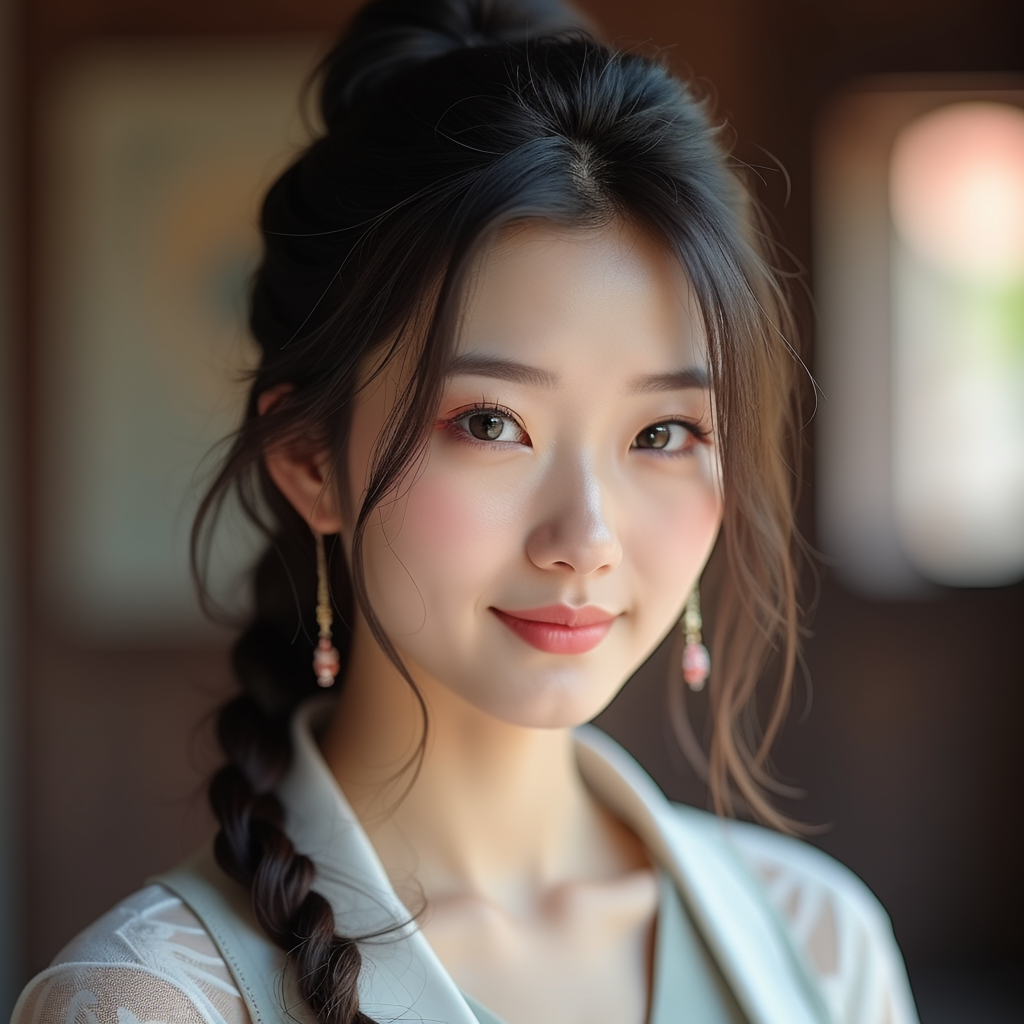

In [7]:
from PIL import Image
image=Image.open('demo_dc_ae.png') 
print(image.size)
image

In [9]:
# 统计参数
total_params = sum(p.numel() for p in dc_ae.parameters())
print(f'{total_params:,} total parameters.')

312,250,275 total parameters.


SANA1.1中使用的DC-AEf32c32参数为312M

In [3]:
from diffusers import AutoencoderKL
import torch
xl_vae = AutoencoderKL.from_pretrained("g:code/model/stable-diffusion-xl-base-1.0", 
                                      subfolder="vae",
                                      torch_dtype=torch.float16).to('cuda')


In [1]:
from torchmetrics.image import StructuralSimilarityIndexMeasure as ssim
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity as lpip
from torchmetrics.image.fid import FrechetInceptionDistance as fid

sdxl的VAE(0.9 version)83M参数

In [ ]:
total_params = sum(p.numel() for p in xl_vae.parameters())
print(f'{total_params:,} total parameters.')

In [21]:
# 比较SDXL-VAE和DC-AE的结构差异
print("=== SDXL-VAE结构 ===")
for name, child in xl_vae.named_children():
    print(f"SDXL-VAE: {name}")
print('-'*50)

print("=== DC-AE结构 ===")
print("整体结构:")
for name, child in dc_vae.named_children():
    print(f"DC-AE: {name}")
print('-'*50)

print("编码器结构:")
for name, child in dc_vae.encoder.named_children():
    print(f"DC-AE Encoder: {name}")
print('-'*50)

print("解码器结构:")
for name, child in dc_vae.decoder.named_children():
    print(f"DC-AE Decoder: {name}")

=== SDXL-VAE结构 ===
SDXL-VAE: encoder
SDXL-VAE: decoder
SDXL-VAE: quant_conv
SDXL-VAE: post_quant_conv
--------------------------------------------------
=== DC-AE结构 ===
整体结构:
DC-AE: encoder
DC-AE: decoder
--------------------------------------------------
编码器结构:
DC-AE Encoder: conv_in
DC-AE Encoder: down_blocks
DC-AE Encoder: conv_out
--------------------------------------------------
解码器结构:
DC-AE Decoder: conv_in
DC-AE Decoder: up_blocks
DC-AE Decoder: norm_out
DC-AE Decoder: conv_act
DC-AE Decoder: conv_out


- **SDXL-VAE**
    - SDXL-VAE.encoder
        - conv_in
        - down_blocks
        - mid_block
        - conv_norm_out
        - conv_act
        - conv_out
    - SDXL-VAE.decoder
        - conv_in
        - up_blocks
        - mid_block
        - conv_norm_out
        - conv_act
        - conv_out
    - SDXL-VAE.quant_conv:Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1))
    - SDXL-VAE.post_quant_conv:Conv2d(4, 4, kernel_size=(1, 1), stride=(1, 1))

- **DC-AE f32c32**
    - DC-AE Encoder
        - conv_in
        - down_blocks
            - 0-2:ResBlock*2+DCdownBlock
            - 3-4:EfficientViTBlock*3+DCDownBlock
            - 5:EfficientViTBlock*3
        - conv_out
    - DC-AE Decoder
        - conv_in
        - up_blocks
            - 0-2:DCUpBlock2d+ResBLock*2
            - 3-4:DCUpBlock2d+EfficientViTBLock*3
            - 5:EfficientViTBlock*3
        - norm_out:RMSNorm()
        - conv_act:ReLu()
        - conv_out

In [91]:
dc_vae.encoder.down_blocks[3][0]

EfficientViTBlock(
  (attn): SanaMultiscaleLinearAttention(
    (to_q): Linear(in_features=512, out_features=512, bias=False)
    (to_k): Linear(in_features=512, out_features=512, bias=False)
    (to_v): Linear(in_features=512, out_features=512, bias=False)
    (to_qkv_multiscale): ModuleList(
      (0): SanaMultiscaleAttentionProjection(
        (proj_in): Conv2d(1536, 1536, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=1536, bias=False)
        (proj_out): Conv2d(1536, 1536, kernel_size=(1, 1), stride=(1, 1), groups=48, bias=False)
      )
    )
    (nonlinearity): ReLU()
    (to_out): Linear(in_features=1024, out_features=512, bias=False)
    (norm_out): RMSNorm()
  )
  (conv_out): GLUMBConv(
    (nonlinearity): SiLU()
    (conv_inverted): Conv2d(512, 4096, kernel_size=(1, 1), stride=(1, 1))
    (conv_depth): Conv2d(4096, 4096, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=4096)
    (conv_point): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False

In [5]:
from diffusers import AutoencoderDC
# 我想要查看AutoencoderDC的适配模型
# 尝试查看类本身的文档字符串，看是否有相关信息
print(AutoencoderDC.__doc__)


    An Autoencoder model introduced in [DCAE](https://arxiv.org/abs/2410.10733) and used in
    [SANA](https://arxiv.org/abs/2410.10629).

    This model inherits from [`ModelMixin`]. Check the superclass documentation for it's generic methods implemented
    for all models (such as downloading or saving).

    Args:
        in_channels (`int`, defaults to `3`):
            The number of input channels in samples.
        latent_channels (`int`, defaults to `32`):
            The number of channels in the latent space representation.
        encoder_block_types (`Union[str, Tuple[str]]`, defaults to `"ResBlock"`):
            The type(s) of block to use in the encoder.
        decoder_block_types (`Union[str, Tuple[str]]`, defaults to `"ResBlock"`):
            The type(s) of block to use in the decoder.
        encoder_block_out_channels (`Tuple[int, ...]`, defaults to `(128, 256, 512, 512, 1024, 1024)`):
            The number of output channels for each block in the encoder.
      